In [17]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder


In [18]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [19]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [21]:
train_df['Sex'].value_counts()

Sex
M    27084
I    23957
F    23010
Name: count, dtype: int64

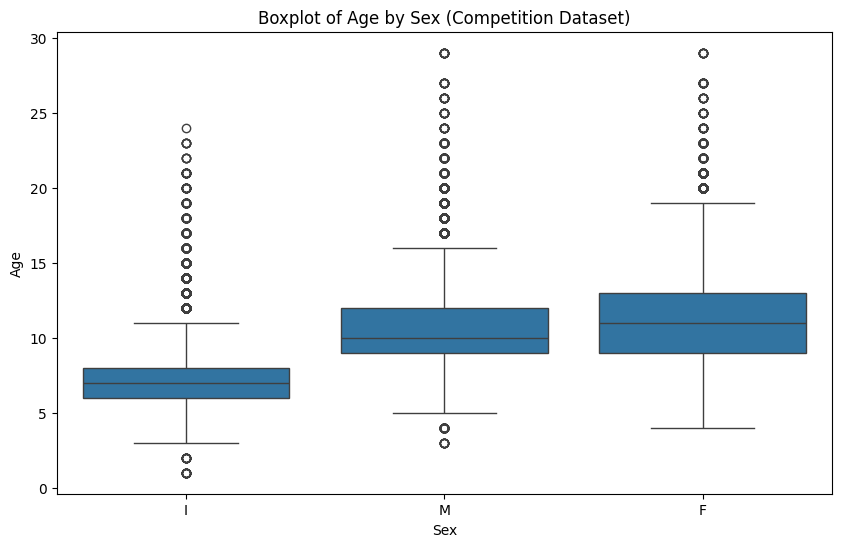

In [22]:
train_df['Sex'] = pd.Categorical(train_df['Sex'], categories=['I', 'M', 'F'], ordered=True)

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Sex', y='Age')
plt.title('Boxplot of Age by Sex (Competition Dataset)')
plt.show()

In [23]:
le = LabelEncoder()

train_df['generated'] = 1
train_df.drop(columns='id', axis=1, inplace=True)

train_df['Sex'] = le.fit_transform(train_df['Sex'])

<Axes: >

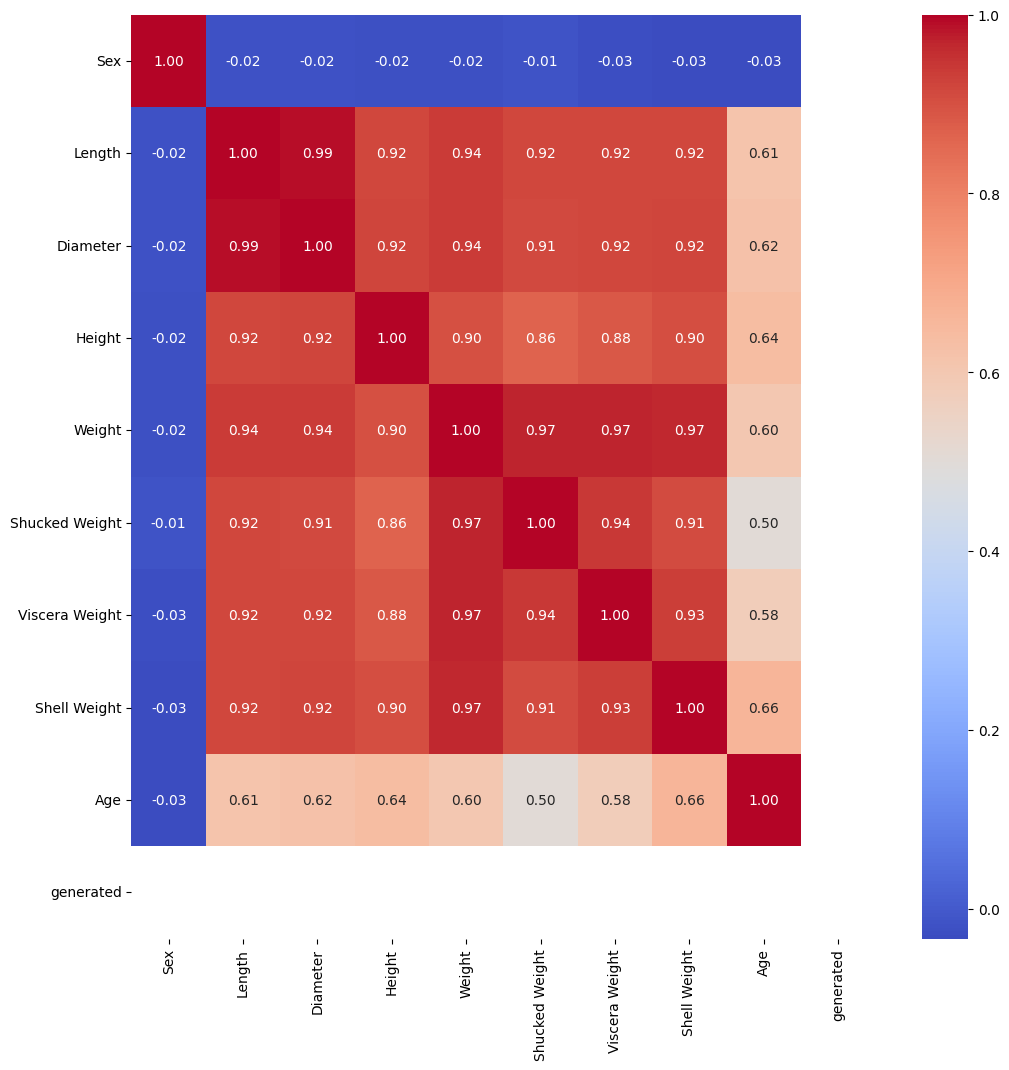

In [24]:
corr = train_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

In [30]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold


In [38]:
X_train = train_df.drop(['Age', 'generated'], axis=1)
y_train = train_df['Age']

X_tester = test_df.drop(columns=['id'], axis=1)
X_tester['Sex'] = le.transform(X_tester['Sex'])

In [35]:
best_mae = float('inf') 
best_fold_index = None
gb_cv_scores, gb_preds = list(), list()

skf = KFold(n_splits=10, random_state=42, shuffle=True)

for i, (train_ix, test_ix) in enumerate(skf.split(X_train, y_train)):

    X_train, X_test = X_train.iloc[train_ix], X_train.iloc[test_ix]
    Y_train, Y_test = y_train.iloc[train_ix], y_train.iloc[test_ix]

    print('---------------------------------------------------------------')

    gb_md = GradientBoostingRegressor(
        loss='absolute_error',
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.01,
        min_samples_split=10,
        min_samples_leaf=20
    ).fit(X_train, Y_train)

    gb_pred_1 = gb_md.predict(X_test)
    gb_pred_2 = gb_md.predict(X_tester)

    gb_score_fold = mean_absolute_error(Y_test, gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)

    print('Fold', i, '==> GradientBoosting of MAE is ==>', gb_score_fold)

    if gb_score_fold < best_mae:
        best_mae = gb_score_fold
        best_fold_index = i

print('Best Fold is', best_fold_index, 'with MAE', best_mae)

---------------------------------------------------------------
Fold 0 ==> GradientBoosting of MAE is ==> 1.3628619935702417
---------------------------------------------------------------
Fold 1 ==> GradientBoosting of MAE is ==> 1.351714716644241
---------------------------------------------------------------
Fold 2 ==> GradientBoosting of MAE is ==> 1.362752800339725
---------------------------------------------------------------
Fold 3 ==> GradientBoosting of MAE is ==> 1.3510053004040228
---------------------------------------------------------------
Fold 4 ==> GradientBoosting of MAE is ==> 1.3400554399678692
---------------------------------------------------------------
Fold 5 ==> GradientBoosting of MAE is ==> 1.3503256848951142
---------------------------------------------------------------
Fold 6 ==> GradientBoosting of MAE is ==> 1.404149436821802
---------------------------------------------------------------
Fold 7 ==> GradientBoosting of MAE is ==> 1.3735239378056747
---

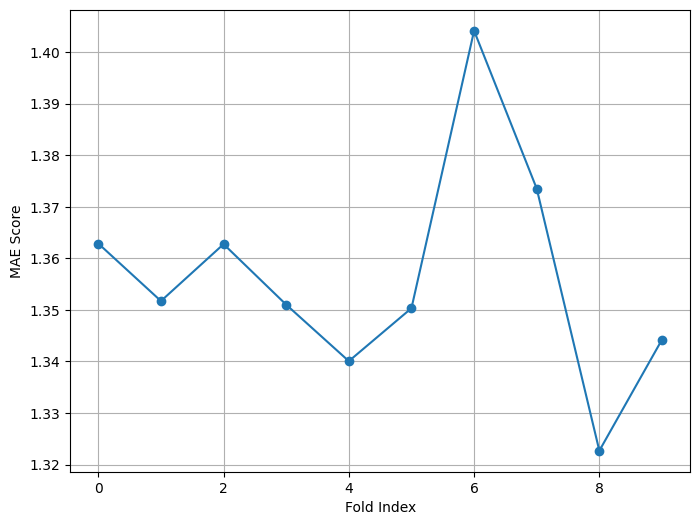

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(gb_cv_scores)), gb_cv_scores, marker='o', linestyle='-')
plt.xlabel('Fold Index')
plt.ylabel('MAE Score')
plt.grid(True)
plt.show()

In [43]:
RandomFR = RFR()
RandomFR.fit(X_train, y_train)
y_pred_rfr = RandomFR.predict(X_test)


In [41]:
scores = cross_val_score(
   estimator= RandomFR,
    X= X_train,
    y= y_train,
    scoring= make_scorer(mean_absolute_error),
    cv = 100,
    n_jobs = -1
)
print("Mean Absolute Error: ", np.mean(scores))

Mean Absolute Error:  1.465999643104643


In [46]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)


In [48]:
submission = pd.DataFrame({'id': test_df['id'], 'Age': gb_preds_test})
submission.to_csv('submission2.csv', index=False)